In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Mon Aug 28 10:58:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   30C    P2    87W / 230W |   6536MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [3]:
n_mels = 1024
n_outputs = 61
n_frames = 400

In [4]:
from model.model_conditional_transformer_reg import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, h_dim=512, out_dim=n_outputs, n_layers=12)
model = model.to(device)
model = model.eval()
print('done')

done


In [6]:
!ls -lt /data/scpark/save/lips/train08.27-3/

total 3125308
-rw-rw-r-- 1 scpark scpark       2376  8월 28 10:26 events.out.tfevents.1693125206.GPUSVR01
-rw-rw-r-- 1 scpark scpark 1066765337  8월 28 08:14 save_20000
-rw-rw-r-- 1 scpark scpark 1066765337  8월 28 00:55 save_10000
-rw-rw-r-- 1 scpark scpark 1066765337  8월 27 17:35 save_0


In [7]:
path = '/data/scpark/save/lips/train08.27-3/save_20000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('done')

done


In [8]:
!ls -lS /Storage/speech/tts/kaist-audio-book/wav/남1_동화1/

total 732912
-rw-r--r-- 1 zeroone scpark  1277038  5월 11 19:49 141.spec.pt
-rwxrwxrwx 1 scpark  vivernd 1199818 11월 13  2019 1181.wav
-rwxrwxrwx 1 scpark  vivernd 1158070 11월 13  2019 1449.wav
-rw-r--r-- 1 zeroone scpark  1086254  5월 11 19:49 232.spec.pt
-rw-r--r-- 1 zeroone scpark  1065710  5월 11 19:49 231.spec.pt
-rw-r--r-- 1 zeroone scpark   983598  5월 11 19:48 763.spec.pt
-rw-r--r-- 1 zeroone scpark   971310  5월 11 19:49 140.spec.pt
-rw-r--r-- 1 zeroone scpark   954929  5월 11 19:48 1801.spec.pt
-rw-r--r-- 1 zeroone scpark   944625  5월 11 19:48 1512.spec.pt
-rw-r--r-- 1 zeroone scpark   944625  5월 11 19:33 1805.spec.pt
-rw-r--r-- 1 zeroone scpark   928238  5월 11 19:48 868.spec.pt
-rw-r--r-- 1 zeroone scpark   920049  5월 11 19:48 1433.spec.pt
-rw-r--r-- 1 zeroone scpark   920049  5월 11 19:48 2007.spec.pt
-rw-r--r-- 1 zeroone scpark   917937  5월 11 19:33 1036.spec.pt
-rw-r--r-- 1 zeroone scpark   917934  5월 11 19:33 257.spec.pt
-rw-r--r-- 1 zeroone scpark   913841  5월 11 19:48 1098.sp

In [9]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
wav2vec = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to(device)
print('done')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


done


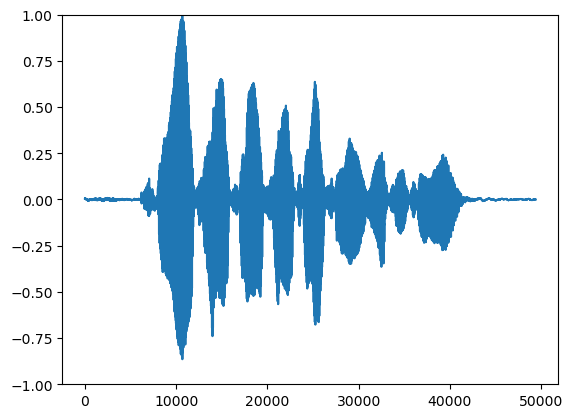

In [11]:
import matplotlib.pyplot as plt
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/남1_동화1/1181.wav'
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/여1_동화1/1181.wav'
wav_file = 'samples/good.wav'
wav, _ = librosa.load(wav_file, sr=16000, res_type='polyphase')
wav = wav / max(abs(wav))

plt.plot(wav)
plt.ylim([-1, 1])
plt.show()

In [14]:
def get_blendshape(wav, sid, layer=24):
    with torch.no_grad():
        wav = torch.Tensor(wav).unsqueeze(0).to(device)
        states = wav2vec(wav, output_hidden_states=True).hidden_states[layer].transpose(1, 2)
        states = F.interpolate(states, scale_factor=3/5, mode='linear').detach()
    sid = torch.Tensor([sid]).long().to(device)
    with torch.no_grad():
        y = model.inference(states, sid=sid,)
        y = torch.clamp(y, min=0, max=1)
    y = y[0].data.cpu().numpy()
    print(wav.shape, y.shape)
    return y
    
ys = []
for sid in range(1, 8):
    y = get_blendshape(wav, sid)
    ys.append(y)
    
ys = np.stack(ys)
print(ys.shape)

np.save('samples/infer08.27-3.npy', ys)
print('done')

torch.Size([1, 49413]) (61, 92)
torch.Size([1, 49413]) (61, 92)
torch.Size([1, 49413]) (61, 92)
torch.Size([1, 49413]) (61, 92)
torch.Size([1, 49413]) (61, 92)
torch.Size([1, 49413]) (61, 92)
torch.Size([1, 49413]) (61, 92)
(7, 61, 92)
done


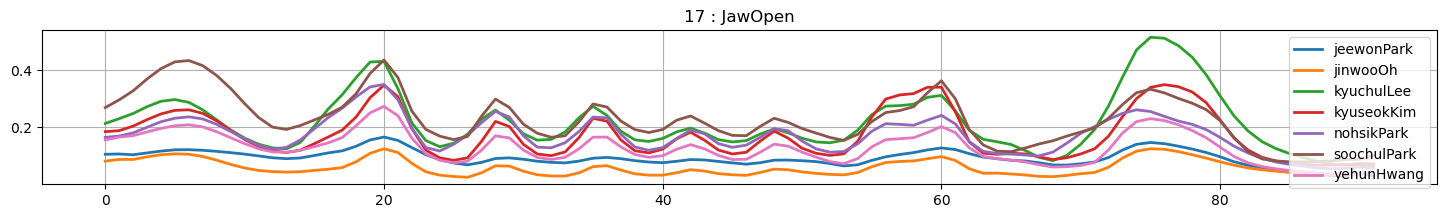

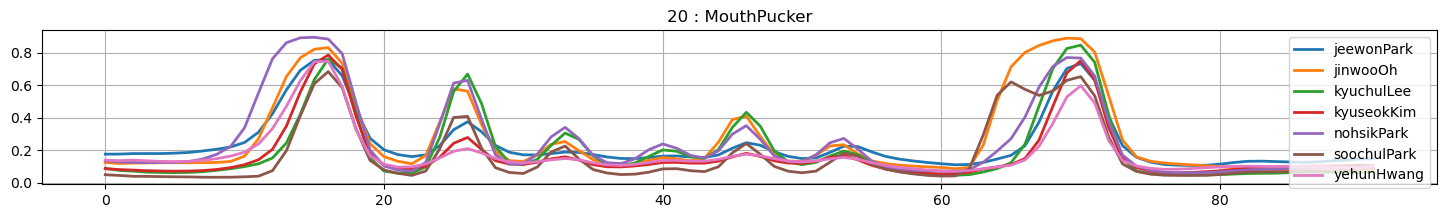

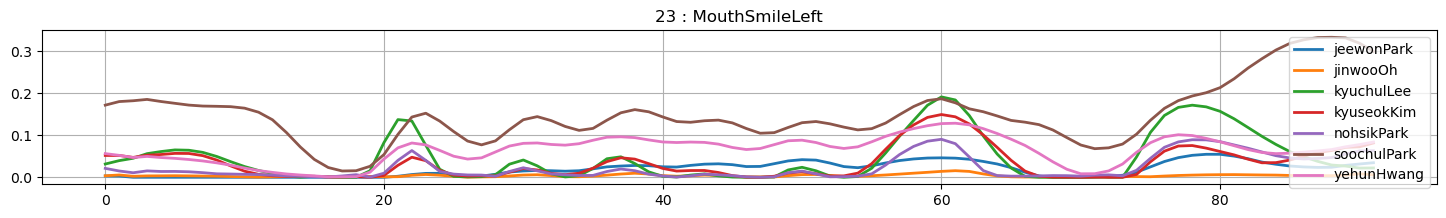

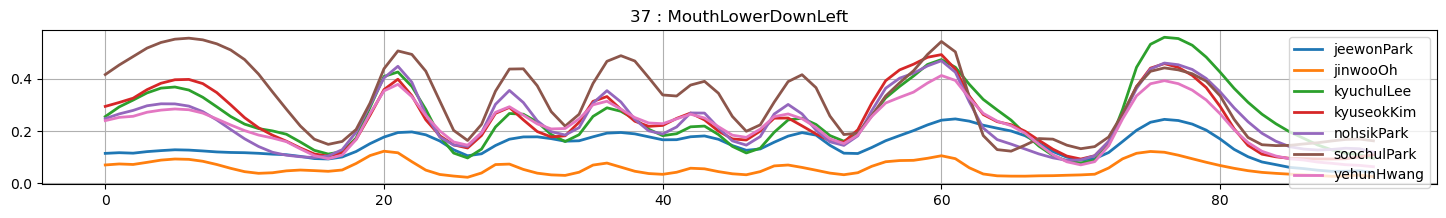

In [15]:
names = ['jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
targets = [(17, 'JawOpen'), (20, 'MouthPucker'), (23, 'MouthSmileLeft'), (37, 'MouthLowerDownLeft')]

for target in targets:
    plt.figure(figsize=[18, 2])
    plt.title(str(target[0]) + ' : ' + target[1])
    for i in range(len(ys)):
        plt.plot(ys[i][target[0]], label=names[i], linewidth=2)
    plt.grid()
    plt.legend()
    plt.show()